In [6]:
import warnings
warnings.filterwarnings("ignore")
import numpy as np
import matplotlib.pyplot as plt
import zipfile
import os
import cv2
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, Conv2DTranspose, Input
from tensorflow.keras.callbacks import EarlyStopping

In [1]:
pip install wandb

Note: you may need to restart the kernel to use updated packages.


In [ ]:
# Log in to your W&B account
import wandb


In [7]:
import wandb
from wandb.keras import WandbMetricsLogger, WandbModelCheckpoint

In [8]:
path_zip = '/kaggle/input/denoising-dirty-documents/'
path = '/kaggle/working/'
with zipfile.ZipFile(path_zip + 'train.zip', 'r') as zip_ref:
    zip_ref.extractall(path)
with zipfile.ZipFile(path_zip + 'test.zip', 'r') as zip_ref:
    zip_ref.extractall(path)    
with zipfile.ZipFile(path_zip + 'train_cleaned.zip', 'r') as zip_ref:
    zip_ref.extractall(path)     
with zipfile.ZipFile(path_zip + 'sampleSubmission.csv.zip', 'r') as zip_ref:
    zip_ref.extractall(path)  

In [9]:
train_img = sorted(os.listdir(path + '/train'))
train_cleaned_img = sorted(os.listdir(path + '/train_cleaned'))
test_img = sorted(os.listdir(path + '/test'))

In [10]:
# process_image function
# dataset_path = "/kaggle/working/train"
def process_image(path):
    img = cv2.imread(path)
    img = np.asarray(img, dtype="float32")
    img = cv2.resize(img, (256,256))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    img = img/255.0
    img = np.reshape(img,(256,256,1))
    
    return img

In [11]:
train = []
train_cleaned = []
test = []

for f in train_img:
    train.append(process_image(path + 'train/' + f))

for f in train_cleaned_img:
    train_cleaned.append(process_image(path + 'train_cleaned/' + f))
   
for f in test_img:
    test.append(process_image(path + 'test/' + f))

# Display some noised images with their denoised images


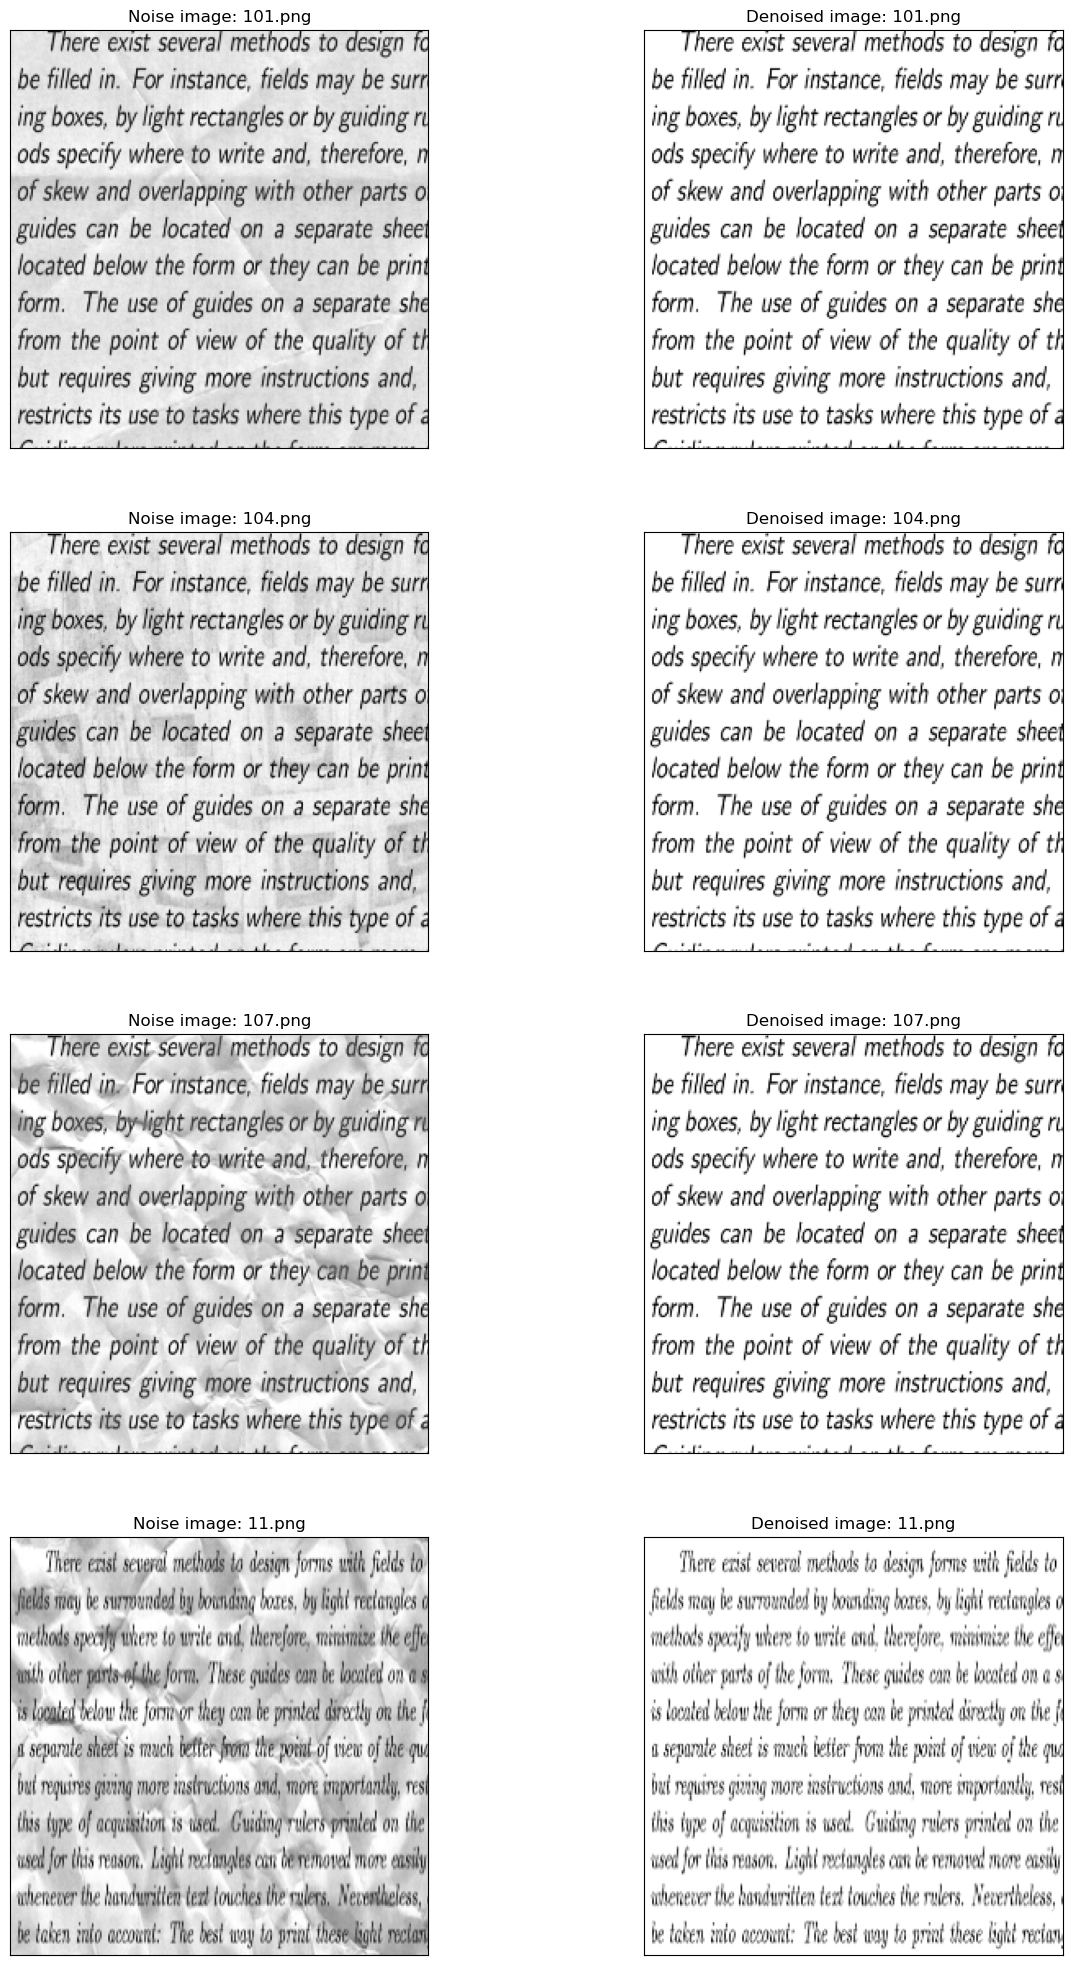

In [12]:
plt.figure(figsize=(15,25))
for i in range(0,8,2):
    plt.subplot(4,2,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(train[i][:,:,0], cmap='gray')
    plt.title('Noise image: {}'.format(train_img[i]))
    
    plt.subplot(4,2,i+2)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(train_cleaned[i][:,:,0], cmap='gray')
    plt.title('Denoised image: {}'.format(train_img[i]))

plt.show()

# convert list to numpy array

In [13]:
X_train = np.asarray(train)
y_train = np.asarray(train_cleaned)
X_test = np.asarray(test)

# Split train images to train and validation

In [16]:
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.15)

In [17]:
import tensorflow as tf

def conv_block(inputs, filters, depth, kernel_size):
    x = inputs
    for _ in range(depth):
        x = tf.keras.layers.Conv2D(filters, kernel_size, strides=1, padding='same')(x)
        x = tf.keras.layers.BatchNormalization()(x)
        x = tf.keras.layers.LeakyReLU(alpha=0.2)(x)
    return x

def erasnet(input_shape, num_classes):
    inputs = tf.keras.layers.Input(shape=input_shape)
    
    # ConvBlock 1
    conv_block1 = conv_block(inputs, 64, depth=2, kernel_size=(5, 5))

    # Residual 1
    residual1 = tf.keras.layers.Conv2D(64, kernel_size=(1, 1), padding='same')(inputs)
    
    # Transition Layer 1
    transition1 = tf.keras.layers.MaxPool2D(pool_size=(2, 2))(conv_block1)
    
    # Dropout 1
    dropout1 = tf.keras.layers.Dropout(0.3)(transition1)

    # ConvBlock 2
    conv_block2 = conv_block(dropout1, 64, depth=2, kernel_size=(5, 5))
    
    # Residual 2
    residual2 = tf.keras.layers.Conv2D(64, kernel_size=(1, 1), padding='same')(transition1)
    
    # Transition Layer 2
    transition2 = tf.keras.layers.MaxPool2D(pool_size=(2, 2))(conv_block2)
    
    # Dropout 2
    dropout2 = tf.keras.layers.Dropout(0.3)(transition2)
    
    # ConvBlock 3
    conv_block3 = conv_block(dropout2, 128, depth=3, kernel_size=(3, 3))
    
    # Residual 3
    residual3 = tf.keras.layers.Conv2D(128, kernel_size=(1, 1), padding='same')(dropout2)
    
    # Transition Layer 3
    transition3 = tf.keras.layers.MaxPool2D(pool_size=(2, 2))(conv_block3)
    
    # Dropout 3
    dropout3 = tf.keras.layers.Dropout(0.3)(transition3)
    
    # ConvBlock 4
    conv_block4 = conv_block(dropout3, 256, depth=3, kernel_size=(3, 3))
    
    # Residual 4
    residual4 = tf.keras.layers.Conv2D(256, kernel_size=(1, 1), padding='same')(dropout3)
    
    # Transition Layer 4
    transition4 = tf.keras.layers.MaxPool2D(pool_size=(2, 2))(conv_block4)
    
    # Dropout 4
    dropout4 = tf.keras.layers.Dropout(0.3)(transition4)
    
    # ConvBlock 5
    conv_block5 = conv_block(dropout4, 512, depth=4, kernel_size=(3, 3))
    
    # ConvTranspose 1
    conv_transpose1 = tf.keras.layers.Conv2DTranspose(256, kernel_size=(3, 3), strides=2, padding='same')(conv_block5)
    
    # Concatenation 1
    concat1 = tf.keras.layers.Concatenate(axis=-1)([conv_transpose1, residual4])
    
    # ConvBlock 6
    conv_block6 = conv_block(concat1, 256, depth=3, kernel_size=(3, 3))
    
    # ConvTranspose 2
    conv_transpose2 = tf.keras.layers.Conv2DTranspose(128, kernel_size=(3, 3), strides=2, padding='same')(conv_block6)
    
    # Concatenation 2
    concat2 = tf.keras.layers.Concatenate(axis=-1)([conv_transpose2, residual3])
    
    # ConvBlock 7
    conv_block7 = conv_block(concat2, 128, depth=3, kernel_size=(3, 3))
    
    # ConvTranspose 3
    conv_transpose3 = tf.keras.layers.Conv2DTranspose(64, kernel_size=(3, 3), strides=2, padding='same')(conv_block7)
    
    # Concatenation 3
    concat3 = tf.keras.layers.Concatenate(axis=-1)([conv_transpose3, residual2])
    
    # ConvBlock 8
    conv_block8 = conv_block(concat3, 64, depth=3, kernel_size=(5, 5))
    
    # ConvTranspose 4
    conv_transpose4 = tf.keras.layers.Conv2DTranspose(64, kernel_size=(3, 3), strides=2, padding='same')(conv_block8)
    
    # Concatenation 4
    concat4 = tf.keras.layers.Concatenate(axis=-1)([conv_transpose4, residual1])
    
    # ConvBlock 9
    conv_block9 = conv_block(concat4, 64, depth=3, kernel_size=(5, 5))
    
    # Convolution 1
    output_conv = tf.keras.layers.Conv2D(num_classes, kernel_size=(3, 3), padding='same')(conv_block9)
    
    # Sigmoid 1
    output_sigmoid = tf.keras.layers.Activation('sigmoid')(output_conv)
    
    model = tf.keras.models.Model(inputs=inputs, outputs=output_sigmoid)
    return model

# input_shape = (256,256, 3)
input_shape = (256, 256, 1)
num_classes = 1

model = erasnet(input_shape, num_classes)
model.summary()


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 256, 256, 64  1664        ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 256, 256, 64  256        ['conv2d[0][0]']                 
 alization)                     )                                                             

In [19]:
def psnr(y_true, y_pred):
    mse = tf.reduce_mean(tf.square(y_true - y_pred))
    max_val = tf.reduce_max(y_true)
    psnr = 20 * tf.math.log(tf.cast(max_val, tf.float32)) - 10 * tf.math.log(mse)
    return psnr

In [21]:
wandb.login()

wandb: WARNING Calling wandb.login() after wandb.init() has no effect.


True

In [23]:
import wandb
from tensorflow.keras.callbacks import EarlyStopping
from wandb.keras import WandbCallback

# Initialize WandB
wandb.init(project='task1', name='Image_Pre')

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mse',psnr])

# Define the early stopping callback
early_stop = EarlyStopping(monitor='loss', patience=10, restore_best_weights=True)

# Train the model
history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=400, batch_size=16, callbacks=[early_stop, WandbCallback()])

# Save the model architecture as JSON
model_json = model.to_json()
with open("model_architecture.json", "w") as json_file:
    json_file.write(model_json)

# Log the model architecture
wandb.save("model_architecture.json")

# Log the model summary
model.summary(print_fn=lambda x: wandb.log({"model_summary": x}))

# Finish the run
wandb.run.finish()


wandb: WARNING The save_model argument by default saves the model in the HDF5 format that cannot save custom objects like subclassed models and custom layers. This behavior will be deprecated in a future release in favor of the SavedModel format. Meanwhile, the HDF5 model is saved as W&B files and the SavedModel as W&B Artifacts.


Epoch 1/400


2023-07-12 15:36:56.731942: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


6/6 [==============================] - ETA: 0s - loss: 0.1488 - mse: 0.1488 - psnr: 20.6240

wandb: Adding directory to artifact (/kaggle/working/wandb/run-20230712_153548-6t1zjkdz/files/model-best)... Done. 0.8s


6/6 [==============================] - 91s 8s/step - loss: 0.1488 - mse: 0.1488 - psnr: 20.6240 - val_loss: 0.8465 - val_mse: 0.8465 - val_psnr: 1.6662
Epoch 2/400
6/6 [==============================] - ETA: 0s - loss: 0.0350 - mse: 0.0350 - psnr: 34.4426

wandb: Adding directory to artifact (/kaggle/working/wandb/run-20230712_153548-6t1zjkdz/files/model-best)... Done. 0.9s


6/6 [==============================] - 25s 5s/step - loss: 0.0350 - mse: 0.0350 - psnr: 34.4426 - val_loss: 0.6609 - val_mse: 0.6609 - val_psnr: 4.1409
Epoch 3/400
6/6 [==============================] - ETA: 0s - loss: 0.0162 - mse: 0.0162 - psnr: 41.5042

wandb: Adding directory to artifact (/kaggle/working/wandb/run-20230712_153548-6t1zjkdz/files/model-best)... Done. 0.8s


6/6 [==============================] - 25s 5s/step - loss: 0.0162 - mse: 0.0162 - psnr: 41.5042 - val_loss: 0.0683 - val_mse: 0.0683 - val_psnr: 26.8360
Epoch 4/400
6/6 [==============================] - ETA: 0s - loss: 0.0110 - mse: 0.0110 - psnr: 45.3518

wandb: Adding directory to artifact (/kaggle/working/wandb/run-20230712_153548-6t1zjkdz/files/model-best)... Done. 0.9s


6/6 [==============================] - 26s 5s/step - loss: 0.0110 - mse: 0.0110 - psnr: 45.3518 - val_loss: 0.0682 - val_mse: 0.0682 - val_psnr: 26.8510
Epoch 5/400
6/6 [==============================] - 7s 1s/step - loss: 0.0076 - mse: 0.0076 - psnr: 48.9773 - val_loss: 0.0682 - val_mse: 0.0682 - val_psnr: 26.8491
Epoch 6/400
6/6 [==============================] - ETA: 0s - loss: 0.0056 - mse: 0.0056 - psnr: 51.7562

wandb: Adding directory to artifact (/kaggle/working/wandb/run-20230712_153548-6t1zjkdz/files/model-best)... Done. 0.8s


6/6 [==============================] - 27s 5s/step - loss: 0.0056 - mse: 0.0056 - psnr: 51.7562 - val_loss: 0.0682 - val_mse: 0.0682 - val_psnr: 26.8601
Epoch 7/400
6/6 [==============================] - 7s 1s/step - loss: 0.0051 - mse: 0.0051 - psnr: 52.9004 - val_loss: 0.0682 - val_mse: 0.0682 - val_psnr: 26.8601
Epoch 8/400
6/6 [==============================] - 7s 1s/step - loss: 0.0040 - mse: 0.0040 - psnr: 55.4328 - val_loss: 0.0767 - val_mse: 0.0767 - val_psnr: 25.6793
Epoch 9/400
6/6 [==============================] - ETA: 0s - loss: 0.0034 - mse: 0.0034 - psnr: 56.9787

wandb: Adding directory to artifact (/kaggle/working/wandb/run-20230712_153548-6t1zjkdz/files/model-best)... Done. 0.8s


6/6 [==============================] - 25s 5s/step - loss: 0.0034 - mse: 0.0034 - psnr: 56.9787 - val_loss: 0.0682 - val_mse: 0.0682 - val_psnr: 26.8602
Epoch 10/400
6/6 [==============================] - ETA: 0s - loss: 0.0033 - mse: 0.0033 - psnr: 57.5133

wandb: Adding directory to artifact (/kaggle/working/wandb/run-20230712_153548-6t1zjkdz/files/model-best)... Done. 0.9s


6/6 [==============================] - 26s 5s/step - loss: 0.0033 - mse: 0.0033 - psnr: 57.5133 - val_loss: 0.0599 - val_mse: 0.0599 - val_psnr: 28.1425
Epoch 11/400
6/6 [==============================] - ETA: 0s - loss: 0.0029 - mse: 0.0029 - psnr: 58.4649

wandb: Adding directory to artifact (/kaggle/working/wandb/run-20230712_153548-6t1zjkdz/files/model-best)... Done. 0.8s


6/6 [==============================] - 26s 5s/step - loss: 0.0029 - mse: 0.0029 - psnr: 58.4649 - val_loss: 0.0365 - val_mse: 0.0365 - val_psnr: 33.0979
Epoch 12/400
6/6 [==============================] - ETA: 0s - loss: 0.0025 - mse: 0.0025 - psnr: 59.8726

wandb: Adding directory to artifact (/kaggle/working/wandb/run-20230712_153548-6t1zjkdz/files/model-best)... Done. 0.8s


6/6 [==============================] - 26s 5s/step - loss: 0.0025 - mse: 0.0025 - psnr: 59.8726 - val_loss: 0.0270 - val_mse: 0.0270 - val_psnr: 36.1196
Epoch 13/400
6/6 [==============================] - 7s 1s/step - loss: 0.0023 - mse: 0.0023 - psnr: 60.8337 - val_loss: 0.0271 - val_mse: 0.0271 - val_psnr: 36.0656
Epoch 14/400
6/6 [==============================] - 7s 1s/step - loss: 0.0023 - mse: 0.0023 - psnr: 60.2738 - val_loss: 0.0447 - val_mse: 0.0447 - val_psnr: 31.0730
Epoch 15/400
6/6 [==============================] - 7s 1s/step - loss: 0.0025 - mse: 0.0025 - psnr: 60.2351 - val_loss: 0.0682 - val_mse: 0.0682 - val_psnr: 26.8599
Epoch 16/400
6/6 [==============================] - 7s 1s/step - loss: 0.0025 - mse: 0.0025 - psnr: 59.9721 - val_loss: 0.0685 - val_mse: 0.0685 - val_psnr: 26.8102
Epoch 17/400
6/6 [==============================] - 7s 1s/step - loss: 0.0024 - mse: 0.0024 - psnr: 60.2450 - val_loss: 0.0679 - val_mse: 0.0679 - val_psnr: 26.8932
Epoch 18/400
6/6 [====

wandb: Adding directory to artifact (/kaggle/working/wandb/run-20230712_153548-6t1zjkdz/files/model-best)... Done. 0.8s


6/6 [==============================] - 25s 5s/step - loss: 0.0020 - mse: 0.0020 - psnr: 62.0931 - val_loss: 0.0243 - val_mse: 0.0243 - val_psnr: 37.1540
Epoch 21/400
6/6 [==============================] - ETA: 0s - loss: 0.0017 - mse: 0.0017 - psnr: 63.3398

wandb: Adding directory to artifact (/kaggle/working/wandb/run-20230712_153548-6t1zjkdz/files/model-best)... Done. 0.8s


6/6 [==============================] - 26s 5s/step - loss: 0.0017 - mse: 0.0017 - psnr: 63.3398 - val_loss: 0.0224 - val_mse: 0.0224 - val_psnr: 37.9844
Epoch 22/400
6/6 [==============================] - ETA: 0s - loss: 0.0017 - mse: 0.0017 - psnr: 63.7596

wandb: Adding directory to artifact (/kaggle/working/wandb/run-20230712_153548-6t1zjkdz/files/model-best)... Done. 0.8s


6/6 [==============================] - 26s 5s/step - loss: 0.0017 - mse: 0.0017 - psnr: 63.7596 - val_loss: 0.0182 - val_mse: 0.0182 - val_psnr: 40.0668
Epoch 23/400
6/6 [==============================] - ETA: 0s - loss: 0.0017 - mse: 0.0017 - psnr: 64.0837

wandb: Adding directory to artifact (/kaggle/working/wandb/run-20230712_153548-6t1zjkdz/files/model-best)... Done. 0.8s


6/6 [==============================] - 25s 5s/step - loss: 0.0017 - mse: 0.0017 - psnr: 64.0837 - val_loss: 0.0132 - val_mse: 0.0132 - val_psnr: 43.2856
Epoch 24/400
6/6 [==============================] - ETA: 0s - loss: 0.0016 - mse: 0.0016 - psnr: 64.2143

wandb: Adding directory to artifact (/kaggle/working/wandb/run-20230712_153548-6t1zjkdz/files/model-best)... Done. 0.8s


6/6 [==============================] - 25s 5s/step - loss: 0.0016 - mse: 0.0016 - psnr: 64.2143 - val_loss: 0.0126 - val_mse: 0.0126 - val_psnr: 43.7203
Epoch 25/400
6/6 [==============================] - ETA: 0s - loss: 0.0017 - mse: 0.0017 - psnr: 64.2403

wandb: Adding directory to artifact (/kaggle/working/wandb/run-20230712_153548-6t1zjkdz/files/model-best)... Done. 0.8s


6/6 [==============================] - 26s 5s/step - loss: 0.0017 - mse: 0.0017 - psnr: 64.2403 - val_loss: 0.0119 - val_mse: 0.0119 - val_psnr: 44.2977
Epoch 26/400
6/6 [==============================] - 7s 1s/step - loss: 0.0017 - mse: 0.0017 - psnr: 63.6633 - val_loss: 0.0121 - val_mse: 0.0121 - val_psnr: 44.1147
Epoch 27/400
6/6 [==============================] - ETA: 0s - loss: 0.0016 - mse: 0.0016 - psnr: 64.4268

wandb: Adding directory to artifact (/kaggle/working/wandb/run-20230712_153548-6t1zjkdz/files/model-best)... Done. 0.8s


6/6 [==============================] - 25s 5s/step - loss: 0.0016 - mse: 0.0016 - psnr: 64.4268 - val_loss: 0.0114 - val_mse: 0.0114 - val_psnr: 44.7176
Epoch 28/400
6/6 [==============================] - ETA: 0s - loss: 0.0015 - mse: 0.0015 - psnr: 65.3563

wandb: Adding directory to artifact (/kaggle/working/wandb/run-20230712_153548-6t1zjkdz/files/model-best)... Done. 0.7s


6/6 [==============================] - 26s 5s/step - loss: 0.0015 - mse: 0.0015 - psnr: 65.3563 - val_loss: 0.0101 - val_mse: 0.0101 - val_psnr: 45.9836
Epoch 29/400
6/6 [==============================] - 7s 1s/step - loss: 0.0014 - mse: 0.0014 - psnr: 65.6470 - val_loss: 0.0110 - val_mse: 0.0110 - val_psnr: 45.1336
Epoch 30/400
6/6 [==============================] - 7s 1s/step - loss: 0.0014 - mse: 0.0014 - psnr: 65.6182 - val_loss: 0.0125 - val_mse: 0.0125 - val_psnr: 43.8131
Epoch 31/400
6/6 [==============================] - 7s 1s/step - loss: 0.0014 - mse: 0.0014 - psnr: 65.9670 - val_loss: 0.0113 - val_mse: 0.0113 - val_psnr: 44.7922
Epoch 32/400
6/6 [==============================] - ETA: 0s - loss: 0.0014 - mse: 0.0014 - psnr: 65.5719

wandb: Adding directory to artifact (/kaggle/working/wandb/run-20230712_153548-6t1zjkdz/files/model-best)... Done. 0.8s


6/6 [==============================] - 25s 5s/step - loss: 0.0014 - mse: 0.0014 - psnr: 65.5719 - val_loss: 0.0092 - val_mse: 0.0092 - val_psnr: 46.8928
Epoch 33/400
6/6 [==============================] - 7s 1s/step - loss: 0.0015 - mse: 0.0015 - psnr: 65.1241 - val_loss: 0.0101 - val_mse: 0.0101 - val_psnr: 45.9334
Epoch 34/400
6/6 [==============================] - 7s 1s/step - loss: 0.0015 - mse: 0.0015 - psnr: 65.0864 - val_loss: 0.0118 - val_mse: 0.0118 - val_psnr: 44.3580
Epoch 35/400
6/6 [==============================] - 7s 1s/step - loss: 0.0014 - mse: 0.0014 - psnr: 65.9901 - val_loss: 0.0122 - val_mse: 0.0122 - val_psnr: 44.0377
Epoch 36/400
6/6 [==============================] - 7s 1s/step - loss: 0.0014 - mse: 0.0014 - psnr: 65.8041 - val_loss: 0.0133 - val_mse: 0.0133 - val_psnr: 43.2161
Epoch 37/400
6/6 [==============================] - 7s 1s/step - loss: 0.0013 - mse: 0.0013 - psnr: 66.1242 - val_loss: 0.0121 - val_mse: 0.0121 - val_psnr: 44.1494
Epoch 38/400
6/6 [====

wandb: Adding directory to artifact (/kaggle/working/wandb/run-20230712_153548-6t1zjkdz/files/model-best)... Done. 0.8s


6/6 [==============================] - 26s 5s/step - loss: 0.0011 - mse: 0.0011 - psnr: 68.1759 - val_loss: 0.0077 - val_mse: 0.0077 - val_psnr: 48.6198
Epoch 58/400
6/6 [==============================] - 7s 1s/step - loss: 0.0010 - mse: 0.0010 - psnr: 68.5814 - val_loss: 0.0079 - val_mse: 0.0079 - val_psnr: 48.3701
Epoch 59/400
6/6 [==============================] - ETA: 0s - loss: 0.0010 - mse: 0.0010 - psnr: 68.7915       

wandb: Adding directory to artifact (/kaggle/working/wandb/run-20230712_153548-6t1zjkdz/files/model-best)... Done. 0.8s


6/6 [==============================] - 25s 5s/step - loss: 0.0010 - mse: 0.0010 - psnr: 68.7915 - val_loss: 0.0074 - val_mse: 0.0074 - val_psnr: 49.0110
Epoch 60/400
6/6 [==============================] - ETA: 0s - loss: 0.0011 - mse: 0.0011 - psnr: 68.5130

wandb: Adding directory to artifact (/kaggle/working/wandb/run-20230712_153548-6t1zjkdz/files/model-best)... Done. 1.0s


6/6 [==============================] - 25s 5s/step - loss: 0.0011 - mse: 0.0011 - psnr: 68.5130 - val_loss: 0.0067 - val_mse: 0.0067 - val_psnr: 50.1101
Epoch 61/400
6/6 [==============================] - ETA: 0s - loss: 0.0010 - mse: 0.0010 - psnr: 68.4841

wandb: Adding directory to artifact (/kaggle/working/wandb/run-20230712_153548-6t1zjkdz/files/model-best)... Done. 0.8s


6/6 [==============================] - 26s 5s/step - loss: 0.0010 - mse: 0.0010 - psnr: 68.4841 - val_loss: 0.0065 - val_mse: 0.0065 - val_psnr: 50.3192
Epoch 62/400
6/6 [==============================] - ETA: 0s - loss: 0.0011 - mse: 0.0011 - psnr: 68.0479

wandb: Adding directory to artifact (/kaggle/working/wandb/run-20230712_153548-6t1zjkdz/files/model-best)... Done. 0.9s


6/6 [==============================] - 26s 5s/step - loss: 0.0011 - mse: 0.0011 - psnr: 68.0479 - val_loss: 0.0057 - val_mse: 0.0057 - val_psnr: 51.6456
Epoch 63/400
6/6 [==============================] - 7s 1s/step - loss: 0.0012 - mse: 0.0012 - psnr: 67.1391 - val_loss: 0.0065 - val_mse: 0.0065 - val_psnr: 50.3484
Epoch 64/400
6/6 [==============================] - 7s 1s/step - loss: 0.0012 - mse: 0.0012 - psnr: 67.6704 - val_loss: 0.0077 - val_mse: 0.0077 - val_psnr: 48.7180
Epoch 65/400
6/6 [==============================] - 7s 1s/step - loss: 0.0011 - mse: 0.0011 - psnr: 68.6218 - val_loss: 0.0070 - val_mse: 0.0070 - val_psnr: 49.6628
Epoch 66/400
6/6 [==============================] - 7s 1s/step - loss: 0.0011 - mse: 0.0011 - psnr: 68.0245 - val_loss: 0.0064 - val_mse: 0.0064 - val_psnr: 50.5098
Epoch 67/400
6/6 [==============================] - ETA: 0s - loss: 0.0011 - mse: 0.0011 - psnr: 68.3726

wandb: Adding directory to artifact (/kaggle/working/wandb/run-20230712_153548-6t1zjkdz/files/model-best)... Done. 0.9s


6/6 [==============================] - 25s 5s/step - loss: 0.0011 - mse: 0.0011 - psnr: 68.3726 - val_loss: 0.0057 - val_mse: 0.0057 - val_psnr: 51.7043
Epoch 68/400
6/6 [==============================] - ETA: 0s - loss: 0.0011 - mse: 0.0011 - psnr: 68.5165

wandb: Adding directory to artifact (/kaggle/working/wandb/run-20230712_153548-6t1zjkdz/files/model-best)... Done. 0.9s


6/6 [==============================] - 26s 5s/step - loss: 0.0011 - mse: 0.0011 - psnr: 68.5165 - val_loss: 0.0050 - val_mse: 0.0050 - val_psnr: 53.0058
Epoch 69/400
6/6 [==============================] - ETA: 0s - loss: 9.8349e-04 - mse: 9.8349e-04 - psnr: 69.3334

wandb: Adding directory to artifact (/kaggle/working/wandb/run-20230712_153548-6t1zjkdz/files/model-best)... Done. 0.8s


6/6 [==============================] - 26s 5s/step - loss: 9.8349e-04 - mse: 9.8349e-04 - psnr: 69.3334 - val_loss: 0.0041 - val_mse: 0.0041 - val_psnr: 55.0153
Epoch 70/400
6/6 [==============================] - ETA: 0s - loss: 9.6449e-04 - mse: 9.6449e-04 - psnr: 69.4711

wandb: Adding directory to artifact (/kaggle/working/wandb/run-20230712_153548-6t1zjkdz/files/model-best)... Done. 0.7s


6/6 [==============================] - 25s 5s/step - loss: 9.6449e-04 - mse: 9.6449e-04 - psnr: 69.4711 - val_loss: 0.0040 - val_mse: 0.0040 - val_psnr: 55.1204
Epoch 71/400
6/6 [==============================] - ETA: 0s - loss: 9.4013e-04 - mse: 9.4013e-04 - psnr: 69.6732

wandb: Adding directory to artifact (/kaggle/working/wandb/run-20230712_153548-6t1zjkdz/files/model-best)... Done. 0.7s


6/6 [==============================] - 26s 5s/step - loss: 9.4013e-04 - mse: 9.4013e-04 - psnr: 69.6732 - val_loss: 0.0038 - val_mse: 0.0038 - val_psnr: 55.6926
Epoch 72/400
6/6 [==============================] - ETA: 0s - loss: 9.4342e-04 - mse: 9.4342e-04 - psnr: 69.6200

wandb: Adding directory to artifact (/kaggle/working/wandb/run-20230712_153548-6t1zjkdz/files/model-best)... Done. 0.8s


6/6 [==============================] - 25s 5s/step - loss: 9.4342e-04 - mse: 9.4342e-04 - psnr: 69.6200 - val_loss: 0.0037 - val_mse: 0.0037 - val_psnr: 55.9621
Epoch 73/400
6/6 [==============================] - 7s 1s/step - loss: 9.2883e-04 - mse: 9.2883e-04 - psnr: 69.9409 - val_loss: 0.0038 - val_mse: 0.0038 - val_psnr: 55.7722
Epoch 74/400
6/6 [==============================] - 7s 1s/step - loss: 9.5939e-04 - mse: 9.5939e-04 - psnr: 69.4860 - val_loss: 0.0039 - val_mse: 0.0039 - val_psnr: 55.4391
Epoch 75/400
6/6 [==============================] - ETA: 0s - loss: 9.3839e-04 - mse: 9.3839e-04 - psnr: 69.8729

wandb: Adding directory to artifact (/kaggle/working/wandb/run-20230712_153548-6t1zjkdz/files/model-best)... Done. 0.8s


6/6 [==============================] - 26s 5s/step - loss: 9.3839e-04 - mse: 9.3839e-04 - psnr: 69.8729 - val_loss: 0.0036 - val_mse: 0.0036 - val_psnr: 56.1318
Epoch 76/400
6/6 [==============================] - 7s 1s/step - loss: 9.5238e-04 - mse: 9.5238e-04 - psnr: 69.5773 - val_loss: 0.0039 - val_mse: 0.0039 - val_psnr: 55.4956
Epoch 77/400
6/6 [==============================] - 7s 1s/step - loss: 9.5826e-04 - mse: 9.5826e-04 - psnr: 69.4231 - val_loss: 0.0038 - val_mse: 0.0038 - val_psnr: 55.8529
Epoch 78/400
6/6 [==============================] - 7s 1s/step - loss: 0.0010 - mse: 0.0010 - psnr: 68.6977 - val_loss: 0.0038 - val_mse: 0.0038 - val_psnr: 55.7819
Epoch 79/400
6/6 [==============================] - 7s 1s/step - loss: 0.0010 - mse: 0.0010 - psnr: 68.8576 - val_loss: 0.0039 - val_mse: 0.0039 - val_psnr: 55.5108
Epoch 80/400
6/6 [==============================] - 7s 1s/step - loss: 9.6872e-04 - mse: 9.6872e-04 - psnr: 69.3242 - val_loss: 0.0038 - val_mse: 0.0038 - val_psnr

wandb: Adding directory to artifact (/kaggle/working/wandb/run-20230712_153548-6t1zjkdz/files/model-best)... Done. 0.9s


6/6 [==============================] - 26s 5s/step - loss: 9.1870e-04 - mse: 9.1870e-04 - psnr: 69.7817 - val_loss: 0.0033 - val_mse: 0.0033 - val_psnr: 57.2718
Epoch 82/400
6/6 [==============================] - ETA: 0s - loss: 9.2640e-04 - mse: 9.2640e-04 - psnr: 69.9711

wandb: Adding directory to artifact (/kaggle/working/wandb/run-20230712_153548-6t1zjkdz/files/model-best)... Done. 0.9s


6/6 [==============================] - 25s 5s/step - loss: 9.2640e-04 - mse: 9.2640e-04 - psnr: 69.9711 - val_loss: 0.0031 - val_mse: 0.0031 - val_psnr: 57.6324
Epoch 83/400
6/6 [==============================] - ETA: 0s - loss: 9.0698e-04 - mse: 9.0698e-04 - psnr: 70.1641

wandb: Adding directory to artifact (/kaggle/working/wandb/run-20230712_153548-6t1zjkdz/files/model-best)... Done. 0.9s


6/6 [==============================] - 26s 5s/step - loss: 9.0698e-04 - mse: 9.0698e-04 - psnr: 70.1641 - val_loss: 0.0030 - val_mse: 0.0030 - val_psnr: 58.2566
Epoch 84/400
6/6 [==============================] - ETA: 0s - loss: 8.8185e-04 - mse: 8.8185e-04 - psnr: 70.1503

wandb: Adding directory to artifact (/kaggle/working/wandb/run-20230712_153548-6t1zjkdz/files/model-best)... Done. 0.8s


6/6 [==============================] - 26s 5s/step - loss: 8.8185e-04 - mse: 8.8185e-04 - psnr: 70.1503 - val_loss: 0.0027 - val_mse: 0.0027 - val_psnr: 59.0842
Epoch 85/400
6/6 [==============================] - ETA: 0s - loss: 9.0452e-04 - mse: 9.0452e-04 - psnr: 69.9944

wandb: Adding directory to artifact (/kaggle/working/wandb/run-20230712_153548-6t1zjkdz/files/model-best)... Done. 0.8s


6/6 [==============================] - 26s 5s/step - loss: 9.0452e-04 - mse: 9.0452e-04 - psnr: 69.9944 - val_loss: 0.0027 - val_mse: 0.0027 - val_psnr: 59.1918
Epoch 86/400
6/6 [==============================] - ETA: 0s - loss: 8.6416e-04 - mse: 8.6416e-04 - psnr: 70.6043

wandb: Adding directory to artifact (/kaggle/working/wandb/run-20230712_153548-6t1zjkdz/files/model-best)... Done. 0.8s


6/6 [==============================] - 26s 5s/step - loss: 8.6416e-04 - mse: 8.6416e-04 - psnr: 70.6043 - val_loss: 0.0024 - val_mse: 0.0024 - val_psnr: 60.1203
Epoch 87/400
6/6 [==============================] - ETA: 0s - loss: 8.7290e-04 - mse: 8.7290e-04 - psnr: 70.3843

wandb: Adding directory to artifact (/kaggle/working/wandb/run-20230712_153548-6t1zjkdz/files/model-best)... Done. 0.8s


6/6 [==============================] - 25s 5s/step - loss: 8.7290e-04 - mse: 8.7290e-04 - psnr: 70.3843 - val_loss: 0.0023 - val_mse: 0.0023 - val_psnr: 60.9546
Epoch 88/400
6/6 [==============================] - ETA: 0s - loss: 8.9626e-04 - mse: 8.9626e-04 - psnr: 70.1973

wandb: Adding directory to artifact (/kaggle/working/wandb/run-20230712_153548-6t1zjkdz/files/model-best)... Done. 0.8s


6/6 [==============================] - 25s 5s/step - loss: 8.9626e-04 - mse: 8.9626e-04 - psnr: 70.1973 - val_loss: 0.0022 - val_mse: 0.0022 - val_psnr: 60.9888
Epoch 89/400
6/6 [==============================] - ETA: 0s - loss: 8.5442e-04 - mse: 8.5442e-04 - psnr: 70.7812

wandb: Adding directory to artifact (/kaggle/working/wandb/run-20230712_153548-6t1zjkdz/files/model-best)... Done. 0.8s


6/6 [==============================] - 26s 5s/step - loss: 8.5442e-04 - mse: 8.5442e-04 - psnr: 70.7812 - val_loss: 0.0021 - val_mse: 0.0021 - val_psnr: 61.5298
Epoch 90/400
6/6 [==============================] - ETA: 0s - loss: 8.5724e-04 - mse: 8.5724e-04 - psnr: 70.8137

wandb: Adding directory to artifact (/kaggle/working/wandb/run-20230712_153548-6t1zjkdz/files/model-best)... Done. 0.8s


6/6 [==============================] - 26s 5s/step - loss: 8.5724e-04 - mse: 8.5724e-04 - psnr: 70.8137 - val_loss: 0.0021 - val_mse: 0.0021 - val_psnr: 61.6141
Epoch 91/400
6/6 [==============================] - ETA: 0s - loss: 8.7925e-04 - mse: 8.7925e-04 - psnr: 70.5458

wandb: Adding directory to artifact (/kaggle/working/wandb/run-20230712_153548-6t1zjkdz/files/model-best)... Done. 0.9s


6/6 [==============================] - 25s 5s/step - loss: 8.7925e-04 - mse: 8.7925e-04 - psnr: 70.5458 - val_loss: 0.0021 - val_mse: 0.0021 - val_psnr: 61.6793
Epoch 92/400
6/6 [==============================] - ETA: 0s - loss: 8.4289e-04 - mse: 8.4289e-04 - psnr: 70.8554

wandb: Adding directory to artifact (/kaggle/working/wandb/run-20230712_153548-6t1zjkdz/files/model-best)... Done. 0.9s


6/6 [==============================] - 26s 5s/step - loss: 8.4289e-04 - mse: 8.4289e-04 - psnr: 70.8554 - val_loss: 0.0020 - val_mse: 0.0020 - val_psnr: 62.1998
Epoch 93/400
6/6 [==============================] - 7s 1s/step - loss: 8.7049e-04 - mse: 8.7049e-04 - psnr: 70.5370 - val_loss: 0.0022 - val_mse: 0.0022 - val_psnr: 61.2185
Epoch 94/400
6/6 [==============================] - 7s 1s/step - loss: 9.0120e-04 - mse: 9.0120e-04 - psnr: 70.4616 - val_loss: 0.0023 - val_mse: 0.0023 - val_psnr: 60.9427
Epoch 95/400
6/6 [==============================] - 7s 1s/step - loss: 9.7234e-04 - mse: 9.7234e-04 - psnr: 69.0878 - val_loss: 0.0022 - val_mse: 0.0022 - val_psnr: 61.2567
Epoch 96/400
6/6 [==============================] - 7s 1s/step - loss: 0.0010 - mse: 0.0010 - psnr: 69.2958 - val_loss: 0.0024 - val_mse: 0.0024 - val_psnr: 60.4370
Epoch 97/400
6/6 [==============================] - 7s 1s/step - loss: 9.3861e-04 - mse: 9.3861e-04 - psnr: 69.7705 - val_loss: 0.0027 - val_mse: 0.0027 - 

wandb: Adding directory to artifact (/kaggle/working/wandb/run-20230712_153548-6t1zjkdz/files/model-best)... Done. 0.9s


6/6 [==============================] - 26s 5s/step - loss: 8.1604e-04 - mse: 8.1604e-04 - psnr: 71.1062 - val_loss: 0.0019 - val_mse: 0.0019 - val_psnr: 62.5464
Epoch 101/400
6/6 [==============================] - ETA: 0s - loss: 7.8452e-04 - mse: 7.8452e-04 - psnr: 71.5105

wandb: Adding directory to artifact (/kaggle/working/wandb/run-20230712_153548-6t1zjkdz/files/model-best)... Done. 0.8s


6/6 [==============================] - 25s 5s/step - loss: 7.8452e-04 - mse: 7.8452e-04 - psnr: 71.5105 - val_loss: 0.0018 - val_mse: 0.0018 - val_psnr: 63.1045
Epoch 102/400
6/6 [==============================] - 7s 1s/step - loss: 7.6440e-04 - mse: 7.6440e-04 - psnr: 71.7894 - val_loss: 0.0020 - val_mse: 0.0020 - val_psnr: 62.2991
Epoch 103/400
6/6 [==============================] - 7s 1s/step - loss: 7.8216e-04 - mse: 7.8216e-04 - psnr: 71.6500 - val_loss: 0.0020 - val_mse: 0.0020 - val_psnr: 62.2985
Epoch 104/400
6/6 [==============================] - 7s 1s/step - loss: 7.7957e-04 - mse: 7.7957e-04 - psnr: 71.6881 - val_loss: 0.0020 - val_mse: 0.0020 - val_psnr: 61.9617
Epoch 105/400
6/6 [==============================] - 7s 1s/step - loss: 7.7706e-04 - mse: 7.7706e-04 - psnr: 71.4135 - val_loss: 0.0023 - val_mse: 0.0023 - val_psnr: 60.7467
Epoch 106/400
6/6 [==============================] - 7s 1s/step - loss: 8.5735e-04 - mse: 8.5735e-04 - psnr: 70.6551 - val_loss: 0.0026 - val_m

wandb: Adding directory to artifact (/kaggle/working/wandb/run-20230712_153548-6t1zjkdz/files/model-best)... Done. 0.8s


6/6 [==============================] - 26s 5s/step - loss: 7.4286e-04 - mse: 7.4286e-04 - psnr: 71.7836 - val_loss: 0.0017 - val_mse: 0.0017 - val_psnr: 63.6081
Epoch 114/400
6/6 [==============================] - ETA: 0s - loss: 7.4965e-04 - mse: 7.4965e-04 - psnr: 71.8574

wandb: Adding directory to artifact (/kaggle/working/wandb/run-20230712_153548-6t1zjkdz/files/model-best)... Done. 0.8s


6/6 [==============================] - 25s 5s/step - loss: 7.4965e-04 - mse: 7.4965e-04 - psnr: 71.8574 - val_loss: 0.0016 - val_mse: 0.0016 - val_psnr: 64.0983
Epoch 115/400
6/6 [==============================] - ETA: 0s - loss: 7.3393e-04 - mse: 7.3393e-04 - psnr: 72.0570

wandb: Adding directory to artifact (/kaggle/working/wandb/run-20230712_153548-6t1zjkdz/files/model-best)... Done. 0.8s


6/6 [==============================] - 25s 5s/step - loss: 7.3393e-04 - mse: 7.3393e-04 - psnr: 72.0570 - val_loss: 0.0015 - val_mse: 0.0015 - val_psnr: 65.0464
Epoch 116/400
6/6 [==============================] - ETA: 0s - loss: 7.1900e-04 - mse: 7.1900e-04 - psnr: 72.4075

wandb: Adding directory to artifact (/kaggle/working/wandb/run-20230712_153548-6t1zjkdz/files/model-best)... Done. 0.8s


6/6 [==============================] - 26s 5s/step - loss: 7.1900e-04 - mse: 7.1900e-04 - psnr: 72.4075 - val_loss: 0.0015 - val_mse: 0.0015 - val_psnr: 65.2577
Epoch 117/400
6/6 [==============================] - ETA: 0s - loss: 7.0976e-04 - mse: 7.0976e-04 - psnr: 72.6222

wandb: Adding directory to artifact (/kaggle/working/wandb/run-20230712_153548-6t1zjkdz/files/model-best)... Done. 0.9s


6/6 [==============================] - 26s 5s/step - loss: 7.0976e-04 - mse: 7.0976e-04 - psnr: 72.6222 - val_loss: 0.0014 - val_mse: 0.0014 - val_psnr: 65.6498
Epoch 118/400
6/6 [==============================] - 7s 1s/step - loss: 7.2078e-04 - mse: 7.2078e-04 - psnr: 72.3243 - val_loss: 0.0016 - val_mse: 0.0016 - val_psnr: 64.6077
Epoch 119/400
6/6 [==============================] - 7s 1s/step - loss: 7.5012e-04 - mse: 7.5012e-04 - psnr: 71.8651 - val_loss: 0.0017 - val_mse: 0.0017 - val_psnr: 64.0510
Epoch 120/400
6/6 [==============================] - 7s 1s/step - loss: 8.0483e-04 - mse: 8.0483e-04 - psnr: 71.1790 - val_loss: 0.0015 - val_mse: 0.0015 - val_psnr: 64.7047
Epoch 121/400
6/6 [==============================] - ETA: 0s - loss: 7.4488e-04 - mse: 7.4488e-04 - psnr: 72.2264

wandb: Adding directory to artifact (/kaggle/working/wandb/run-20230712_153548-6t1zjkdz/files/model-best)... Done. 0.8s


6/6 [==============================] - 26s 5s/step - loss: 7.4488e-04 - mse: 7.4488e-04 - psnr: 72.2264 - val_loss: 0.0013 - val_mse: 0.0013 - val_psnr: 66.4150
Epoch 122/400
6/6 [==============================] - ETA: 0s - loss: 7.6579e-04 - mse: 7.6579e-04 - psnr: 71.7934

wandb: Adding directory to artifact (/kaggle/working/wandb/run-20230712_153548-6t1zjkdz/files/model-best)... Done. 0.8s


6/6 [==============================] - 26s 5s/step - loss: 7.6579e-04 - mse: 7.6579e-04 - psnr: 71.7934 - val_loss: 0.0013 - val_mse: 0.0013 - val_psnr: 66.7612
Epoch 123/400
6/6 [==============================] - ETA: 0s - loss: 7.8167e-04 - mse: 7.8167e-04 - psnr: 71.3583

wandb: Adding directory to artifact (/kaggle/working/wandb/run-20230712_153548-6t1zjkdz/files/model-best)... Done. 0.8s


6/6 [==============================] - 26s 5s/step - loss: 7.8167e-04 - mse: 7.8167e-04 - psnr: 71.3583 - val_loss: 0.0012 - val_mse: 0.0012 - val_psnr: 67.3346
Epoch 124/400
6/6 [==============================] - 7s 1s/step - loss: 7.2816e-04 - mse: 7.2816e-04 - psnr: 72.3392 - val_loss: 0.0013 - val_mse: 0.0013 - val_psnr: 66.6469
Epoch 125/400
6/6 [==============================] - ETA: 0s - loss: 7.0278e-04 - mse: 7.0278e-04 - psnr: 72.6484

wandb: Adding directory to artifact (/kaggle/working/wandb/run-20230712_153548-6t1zjkdz/files/model-best)... Done. 0.8s


6/6 [==============================] - 26s 5s/step - loss: 7.0278e-04 - mse: 7.0278e-04 - psnr: 72.6484 - val_loss: 0.0011 - val_mse: 0.0011 - val_psnr: 68.0184
Epoch 126/400
6/6 [==============================] - ETA: 0s - loss: 6.9424e-04 - mse: 6.9424e-04 - psnr: 72.6893

wandb: Adding directory to artifact (/kaggle/working/wandb/run-20230712_153548-6t1zjkdz/files/model-best)... Done. 0.8s


6/6 [==============================] - 26s 5s/step - loss: 6.9424e-04 - mse: 6.9424e-04 - psnr: 72.6893 - val_loss: 0.0011 - val_mse: 0.0011 - val_psnr: 68.2179
Epoch 127/400
6/6 [==============================] - 7s 1s/step - loss: 7.4675e-04 - mse: 7.4675e-04 - psnr: 71.8747 - val_loss: 0.0012 - val_mse: 0.0012 - val_psnr: 67.6136
Epoch 128/400
6/6 [==============================] - 7s 1s/step - loss: 8.1547e-04 - mse: 8.1547e-04 - psnr: 71.3087 - val_loss: 0.0011 - val_mse: 0.0011 - val_psnr: 67.8233
Epoch 129/400
6/6 [==============================] - ETA: 0s - loss: 7.0786e-04 - mse: 7.0786e-04 - psnr: 72.3891

wandb: Adding directory to artifact (/kaggle/working/wandb/run-20230712_153548-6t1zjkdz/files/model-best)... Done. 0.8s


6/6 [==============================] - 26s 5s/step - loss: 7.0786e-04 - mse: 7.0786e-04 - psnr: 72.3891 - val_loss: 0.0011 - val_mse: 0.0011 - val_psnr: 68.3057
Epoch 130/400
6/6 [==============================] - ETA: 0s - loss: 7.0815e-04 - mse: 7.0815e-04 - psnr: 72.5284

wandb: Adding directory to artifact (/kaggle/working/wandb/run-20230712_153548-6t1zjkdz/files/model-best)... Done. 0.9s


6/6 [==============================] - 26s 5s/step - loss: 7.0815e-04 - mse: 7.0815e-04 - psnr: 72.5284 - val_loss: 0.0010 - val_mse: 0.0010 - val_psnr: 68.7096
Epoch 131/400
6/6 [==============================] - ETA: 0s - loss: 7.7203e-04 - mse: 7.7203e-04 - psnr: 71.7790

wandb: Adding directory to artifact (/kaggle/working/wandb/run-20230712_153548-6t1zjkdz/files/model-best)... Done. 0.9s


6/6 [==============================] - 26s 5s/step - loss: 7.7203e-04 - mse: 7.7203e-04 - psnr: 71.7790 - val_loss: 9.3340e-04 - val_mse: 9.3340e-04 - val_psnr: 69.7668
Epoch 132/400
6/6 [==============================] - 7s 1s/step - loss: 7.0885e-04 - mse: 7.0885e-04 - psnr: 72.4520 - val_loss: 9.8200e-04 - val_mse: 9.8200e-04 - val_psnr: 69.2592
Epoch 133/400
6/6 [==============================] - 7s 1s/step - loss: 7.8027e-04 - mse: 7.8027e-04 - psnr: 71.3583 - val_loss: 0.0011 - val_mse: 0.0011 - val_psnr: 67.9695
Epoch 134/400
6/6 [==============================] - 7s 1s/step - loss: 7.5271e-04 - mse: 7.5271e-04 - psnr: 71.7370 - val_loss: 0.0011 - val_mse: 0.0011 - val_psnr: 68.4318
Epoch 135/400
6/6 [==============================] - 7s 1s/step - loss: 7.3452e-04 - mse: 7.3452e-04 - psnr: 72.1518 - val_loss: 0.0011 - val_mse: 0.0011 - val_psnr: 68.2233
Epoch 136/400
6/6 [==============================] - 7s 1s/step - loss: 7.1532e-04 - mse: 7.1532e-04 - psnr: 72.4156 - val_loss

In [ ]:
# model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mse',psnr])
# early_stop = EarlyStopping(monitor='loss', patience=10, restore_best_weights=True)
# history= model.fit(X_train, y_train, validation_data = (X_val, y_val), epochs=400, batch_size=16, callbacks= [early_stop])

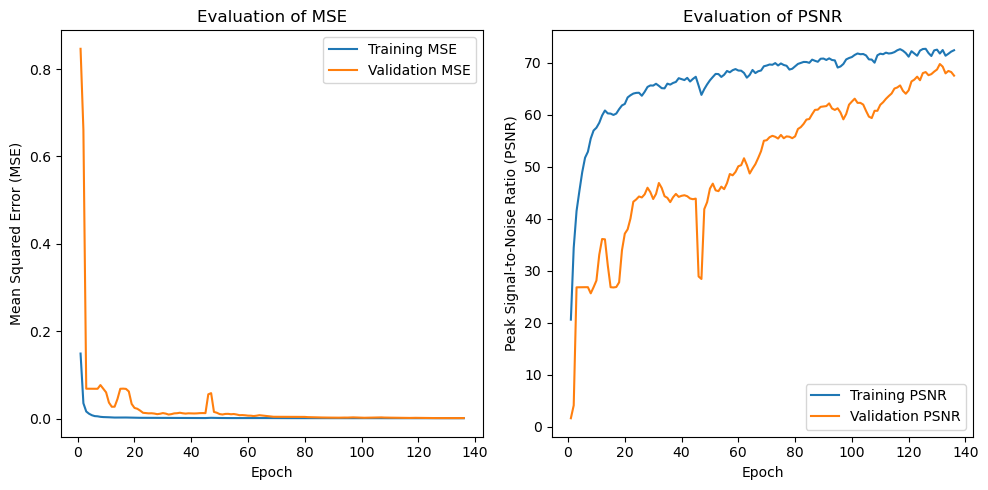

In [29]:
mse = history.history['mse']
val_mse = history.history['val_mse']
psnr = history.history['psnr']
val_psnr = history.history['val_psnr']

# Plot the MSE
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.plot(range(1, len(mse) + 1), mse, label='Training MSE')
plt.plot(range(1, len(val_mse) + 1), val_mse, label='Validation MSE')
plt.xlabel('Epoch')
plt.ylabel('Mean Squared Error (MSE)')
plt.title('Evaluation of MSE')
plt.legend()

# Plot the PSNR
plt.subplot(1, 2, 2)
plt.plot(range(1, len(psnr) + 1), psnr, label='Training PSNR')
plt.plot(range(1, len(val_psnr) + 1), val_psnr, label='Validation PSNR')
plt.xlabel('Epoch')
plt.ylabel('Peak Signal-to-Noise Ratio (PSNR)')
plt.title('Evaluation of PSNR')
plt.legend()

plt.tight_layout()
plt.show()

In [24]:
y_pred = model.predict(X_test, batch_size=16)

5/5 [==============================] - 7s 2s/step


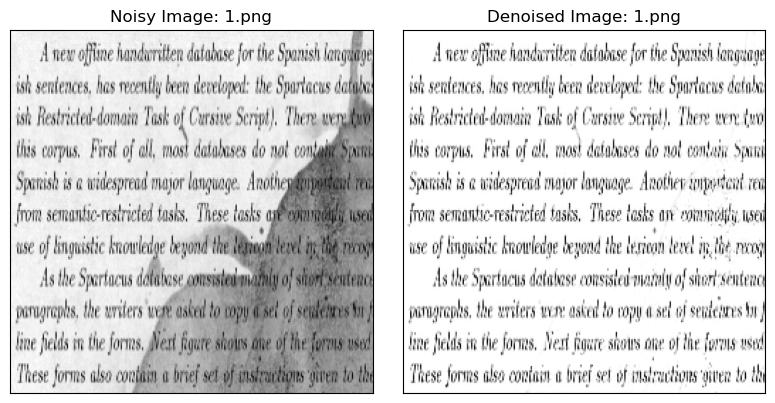

Time taken: 0.56 seconds


In [25]:
import time
# Start the timer
start_time = time.time()
# Your task code here
plt.figure(figsize=(8, 4))
plt.subplot(1, 2, 1)
plt.xticks([])
plt.yticks([])
plt.imshow(X_test[0][:, :, 0], cmap='gray')
plt.title('Noisy Image: {}'.format(test_img[0]))

plt.subplot(1, 2, 2)
plt.xticks([])
plt.yticks([])
plt.imshow(y_pred[0][:, :, 0], cmap='gray')
plt.title('Denoised Image: {}'.format(test_img[0]))

plt.tight_layout()
plt.show()

# Calculate the elapsed time
elapsed_time = time.time() - start_time
print("Time taken: {:.2f} seconds".format(elapsed_time))


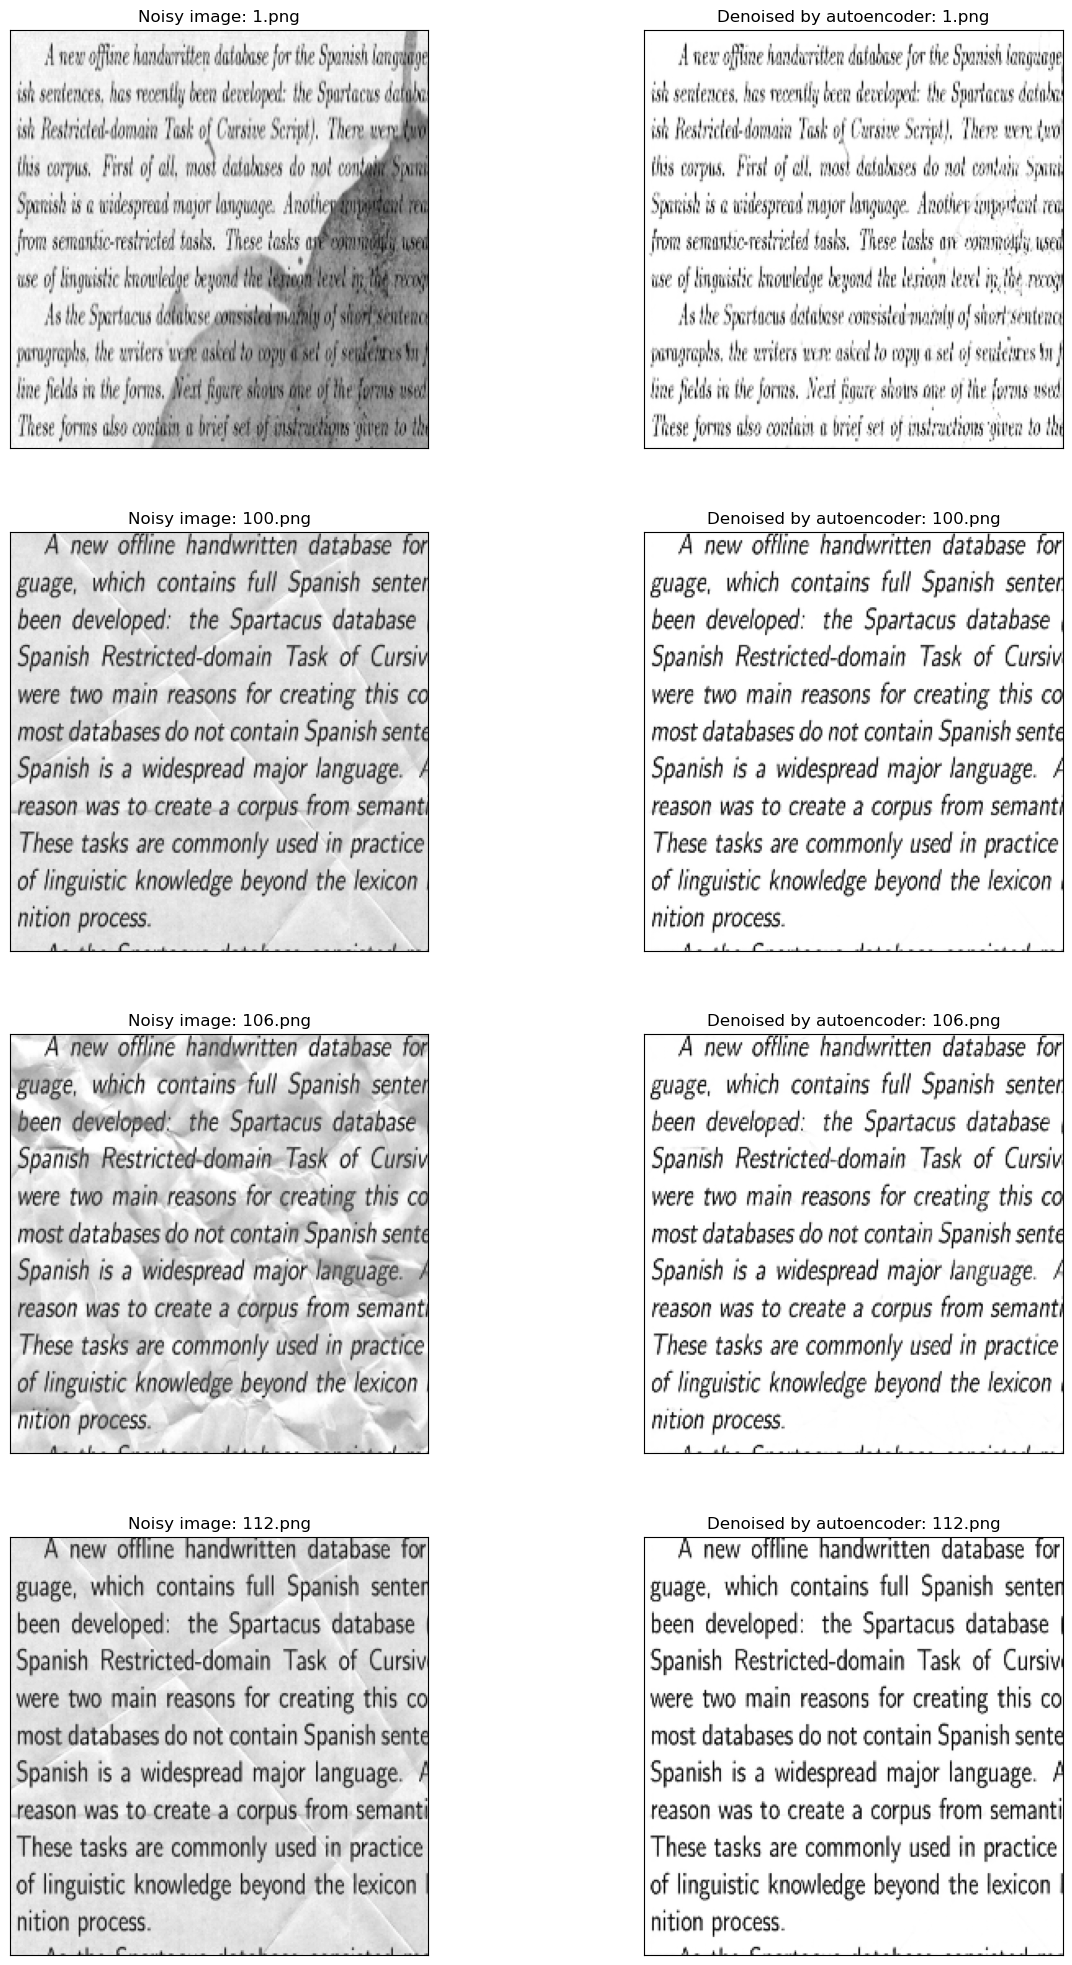

In [26]:
plt.figure(figsize=(15,25))
for i in range(0,8,2):
    plt.subplot(4,2,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(X_test[i][:,:,0], cmap='gray')
    plt.title('Noisy image: {}'.format(test_img[i]))
    
    plt.subplot(4,2,i+2)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(y_pred[i][:,:,0], cmap='gray')
    plt.title('Denoised by autoencoder: {}'.format(test_img[i]))

plt.show()

In [18]:
# model.save("/kaggle/working/Denoising_model.h5")